## Convection-Diffusion (ConFusion) Example} in Fenics

We first set up the problem domain: Let $\Omega = [0, 10]\times[0,2]$

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import math

# Solves the steady linear convection-diffusion problem.                         
# Setup Mesh                                                                     
ny = 50
nx = 5*ny
corner1=Point(0.0,0.0)
corner2=Point(10.0,2.0)
mymesh = RectangleMesh(corner1,corner2, nx, ny)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


And now we spdcify the PDE:

On $\Omega$
$$
\large
-\nabla \cdot((a+\tanh(c((x-x_c)^2 + (y-y_c)^2))\nabla u) + b [ -x_d ~~ y_d ]^\top \cdot \nabla u = f(x)=1.
$$

where we let $a=.05$, $c=10$, $x_c=5$, $y_c=1$, $b=100$, $y_d=-1$ and $x_d=0$.

In [10]:
f = Constant((1.0)) # RHS  

# Define convection and diffusion  
diffusion = Expression('A+tanh(cut*(pow(x[0]-XC,2) + pow(x[1]-YC,2)))',degree=2,A=.05,cut=10,XC=5.0,YC=1.0)
convection = Expression(('B*xd','B*yd'),degree=0,B=100,xd=-1,yd=0)

We define our QoI $Q(u)=(u,\psi)$ as a subdomain average over the box $[1.0,.5]\times [3.0,.75]$


In [11]:
# Define QoI as average value over box                                           
boxX = [1.0, 3.0]
boxY = [0.5, .75]
class MyExpression0(Expression):
    def __init__(self,boxX,boxY,degree=2):
        self.boxX=boxX
        self.boxY=boxY
        self.area = (boxX[1]-boxX[0])*(boxY[1]-boxY[0])

    def eval(self,value, x):
        if x[0] >= self.boxX[0] and x[0] <= self.boxX[1] and x[1] >= self.boxY[0\
] and x[1] <= self.boxY[1]:
            value[0] = 1.0/self.area
        else:
            value[0] = 0.0
psi = MyExpression0(boxX=boxX, boxY=boxY,degree=2)

We now setup the forward problem, solved with linear Lagrange elements, and the boundary conditions: 

* The inflow boundary (at $x=10$) has a parabolic Dirichlet condition
* outflow boundary (\at $x=0$) is homogeneous Neumann. 
* The other BC's are homogeneous Dirichlet.


We solve the above problem using piecewise-linear continuous elements and the adjoint is solved using pi\
ecewise-quadratic elements on the same mesh.


In [12]:
# Define forward problem                                                         
V1 = FunctionSpace(mymesh, 'Lagrange', 1)

# Define Boundary Subdomains and BCS                                             
class RightBoundary(SubDomain):  # define the Dirichlet boundary                 
    def inside(self, x, on_boundary):
        return x[0] > (10.0 - 5.0*DOLFIN_EPS) and on_boundary

class TBBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > DOLFIN_EPS and x[0] < (10.0 - DOLFIN_EPS) and on_boundary
    
RightBC = Expression("x[1]*(2.0-x[1])",degree=2)
ZeroBC = Constant(0.0)

bcr = DirichletBC(V1, RightBC, RightBoundary())
bctb = DirichletBC(V1, ZeroBC, TBBoundary())

u1 = TrialFunction(V1)
v1 = TestFunction(V1)

We now define and solve the weak form of the forward problem and plot the results.

Computed QoI:  0.822076087444


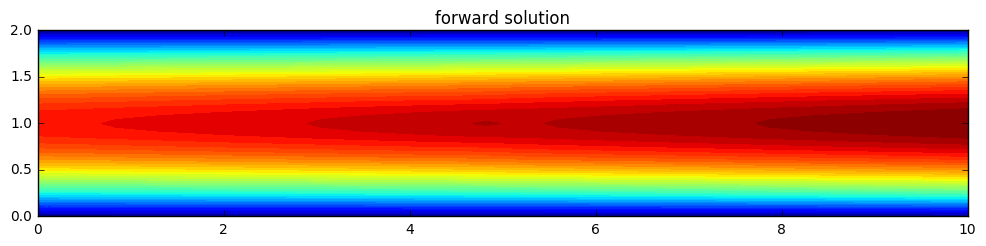

In [13]:
a1 = (dot(convection, grad(u1))*v1 + diffusion*inner(nabla_grad(u1), nabla_grad(v1)))*dx
L1 = f*v1*dx
# Solve Forward problem                                                          
u1 = Function(V1)
solve(a1 == L1, u1, [bcr,bctb])

# Calculate QoI                                                                  
q = assemble(dot(u1,psi)*dx)
print "Computed QoI: ", q

# Save Solution                                                                  
#file = File("plots/forward.pvd")
#u1.rename("u1", "Forward Solution")
# Plot solution                                                                  
plot(u1, interactive=True, title='forward solution')                         

We now 
* define the adjoint problem for adjoint variable u2.
* solve for $u2$ using piecewise quadratics.
* Plot the adjoint solution.

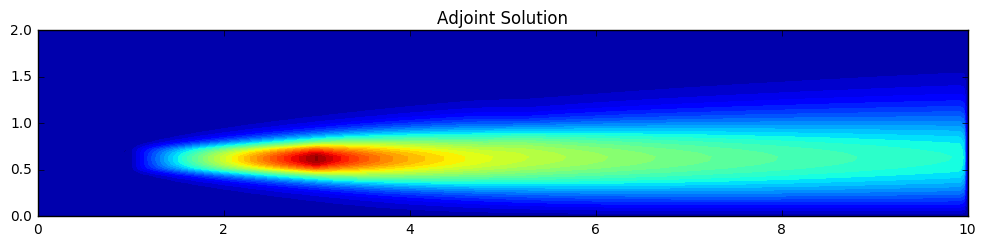

In [14]:
# Define adjoint problem                                                         
V2 = FunctionSpace(mymesh, 'Lagrange', 2)
u2 = TrialFunction(V2)
v2 = TestFunction(V2)

a2 = (-div(convection*u2)*v2 + diffusion*inner(nabla_grad(u2), nabla_grad(v2)))*dx
L2 = psi*v2*dx
bcr = DirichletBC(V2, ZeroBC, RightBoundary())
bctb = DirichletBC(V2, ZeroBC, TBBoundary())

# Solve adjoint problem                                                          
u2 = Function(V2)
solve(a2 == L2, u2, [bcr, bctb])

# Save adjoint solution                                                          
#file = File("plots/adjoint.pvd")
#u2.rename("u2", "Adjoint Solution")
#file << u2
# Plot adjoint solution                                                          
plot(u2, interactive=True, title = 'Adjoint Solution')
     

Error estimate:  7.63127133457e-05
Error estimate: 7.63127133264e-05


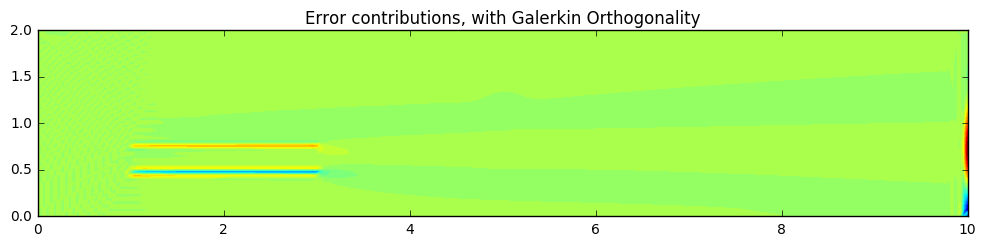

In [15]:
# Error identifier                                                               
f = interpolate(f,V1)
Pu2=interpolate(u2,V1)
uminusPu=project(u2-Pu2,V1)
errorID = (f*(u2-Pu2) - dot(convection, grad(u1))*(u2-Pu2)- diffusion*inner(nabla_grad(u1),\
 nabla_grad(u2-Pu2)))
errorIDGal=(f*(u2) - dot(convection, grad(u1))*(u2)- diffusion*inner(nabla_grad(u1),\
 nabla_grad(u2)))
errorEstimate = assemble(errorID*dx)
errorEst2=assemble(errorIDGal*dx)
print "Error estimate: ", errorEstimate
print "Error estimate:", errorEst2
#plot(errorID, interactive=True, title = 'error identifier')                     
file = File("plots/errorID.pvd")
errorID = project(errorID, V1)
#errorID.rename("errorID", "error identifier")
plot(errorID,title="Error contributions, with Galerkin Orthogonality")

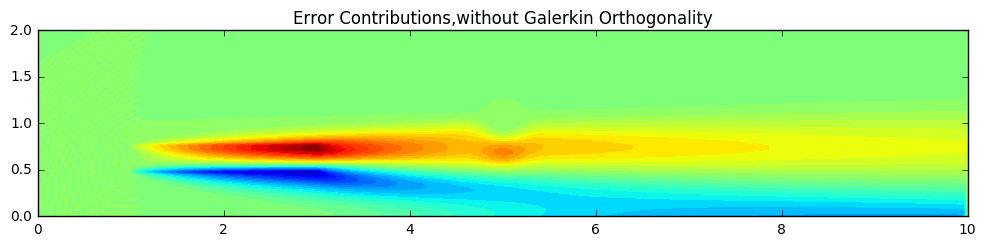

In [9]:
plot(errorIDGal, title="Error Contributions,without Galerkin Orthogonality")

In [ ]:
#sensitivity with respect to convection coeff
#dQdB =  - .01*dot(convection, grad(u1))*u2*dx
#plot(dQdB)